# TASK4
The goal of this subtask is to develop your own model and use it to learn the sine function on the interval [0, 2π]. Discretize the interval with a suitable number of points (of your choice) and use the values of the sine function at these discretization points as labels.

<a id="0"></a>
1. [Data preparation](#1)
2. [Ansatz](#2)
3. [Training](#3)
4. [Experiment 1 - test set from data preparation stage](#4)
5. [Experiment 2 - different range of the input domain: $[2\pi, 7\pi]$](#5)
6. [Adjustment of number of points](#6)
7. [Training for more complicated function](#7)

<a id="1"></a>
## Data preparation
Let's start by generating training and test data.
This function generates a dataset to learn the sine function over the interval $[0,2\pi]$. It discretizes the interval into `num_points = 1000` points, computes the sine of these points, shuffles the points, and then splits them into training and testing sets based on the `test_split=0.2` proportion.

In [5]:
from modules.utils import create_data_sin_function

X_train, Y_train, X_test, Y_test = create_data_sin_function(1000)

Y_train: Length: 800
Y_test: Length: 200


<a id="2"></a>
## Ansatz
Based on article [Schuld, Maria et.al "The effect of data encoding on the expressive power of variational quantum machine learning models"](https://arxiv.org/abs/2008.08605), we learned that the expressivity of the corresponding quantum model is fundamentally limited by the data encoding.
Inspired by this article, specifically Section II. A, we have chosen the following ansatz in a slightly modified form, but based on the same principles.
We use a single-qubit gate generator, $H = \left(\frac{1}{2}\right)\sigma_x.$
That models always lead to functions of the form $f(x) = A \sin(2 \gamma x + B) + C$, where $A,B,C$ are constants determined by the non-encoding part of the variational circuit ([Structure optimization for parameterized quantum circuits](https://arxiv.org/abs/1905.09692)).
Our data ($g(x)$) is in a form $g(x) =sin(x)$.

(<Figure size 600x200 with 1 Axes>, <Axes: >)

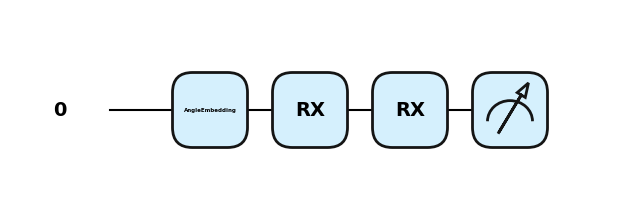

In [6]:
import pennylane as qml
from pennylane import numpy as np

dev = qml.device('default.qubit', wires=1)
@qml.qnode(dev)
def quantum_circuit(x,weights):
    # S(x) - below code can be changed as qml.RX(x, wires=[0])
    qml.AngleEmbedding(x, wires=[0])
    # Ansatz - W(θ)
    qml.RX(weights[0], wires=0)
    qml.RX(weights[1], wires=0)
    return qml.expval(qml.PauliZ(wires=0))


weights = [0.2,0.3]
x_input = [0.2]
quantum_circuit(x_input,weights)
qml.draw_mpl(quantum_circuit,style='pennylane')(x_input,weights)

<a id="3"></a>
## Training
During the training process, we use the Gradient Descent Optimizer to minimize the Mean Squared Error (MSE) cost function over 30 epochs. The parameters of the quantum circuit are initially set to small values and are updated iteratively to fit the sine function based on the provided training data.

In our code, it is possible to change the cost function to the Mean Absolute Error (MAE) by using `cost_MAE`.

In [6]:
import pennylane as qml
import pennylane.numpy as np
from modules.training import cost_MSE, training
from modules.utils import create_data_sin_function

X_train, Y_train, X_test, Y_test = create_data_sin_function(1000)

num_epochs = 30
opt = qml.GradientDescentOptimizer(stepsize=0.1)
init_params = np.array([0.1, 0.1], requires_grad=True)

final_params,costs = training(num_epochs, opt, cost_MSE,init_params, X_train, Y_train)

Y_train: Length: 800
Y_test: Length: 200
Epoch: 0 | Cost: 1.0195956
Epoch: 1 | Cost: 0.7987311
Epoch: 2 | Cost: 0.5963290
Epoch: 3 | Cost: 0.4268439
Epoch: 4 | Cost: 0.2954775
Epoch: 5 | Cost: 0.1996152
Epoch: 6 | Cost: 0.1326374
Epoch: 7 | Cost: 0.0871983
Epoch: 8 | Cost: 0.0569517
Epoch: 9 | Cost: 0.0370542
Epoch: 10 | Cost: 0.0240570
Epoch: 11 | Cost: 0.0156017
Epoch: 12 | Cost: 0.0101134
Epoch: 13 | Cost: 0.0065551
Epoch: 14 | Cost: 0.0042490
Epoch: 15 | Cost: 0.0027547
Epoch: 16 | Cost: 0.0017862
Epoch: 17 | Cost: 0.0011585
Epoch: 18 | Cost: 0.0007515
Epoch: 19 | Cost: 0.0004876
Epoch: 20 | Cost: 0.0003164
Epoch: 21 | Cost: 0.0002054
Epoch: 22 | Cost: 0.0001333
Epoch: 23 | Cost: 0.0000865
Epoch: 24 | Cost: 0.0000562
Epoch: 25 | Cost: 0.0000365
Epoch: 26 | Cost: 0.0000237
Epoch: 27 | Cost: 0.0000154
Epoch: 28 | Cost: 0.0000100
Epoch: 29 | Cost: 0.0000065
Final parameters:  [-0.78357105 -0.78357105]


<a id="4"></a>
### Experiment 1 - test set from data preparation stage
During the initial phase of data generation, we partitioned our dataset into training and test subsets.
 At this stage, we compute the performance metrics for the test dataset to evaluate the model's generalization capability.

Cost (MSE) for training set: 0.0000060
Cost (MSE) for test set: 0.0000064


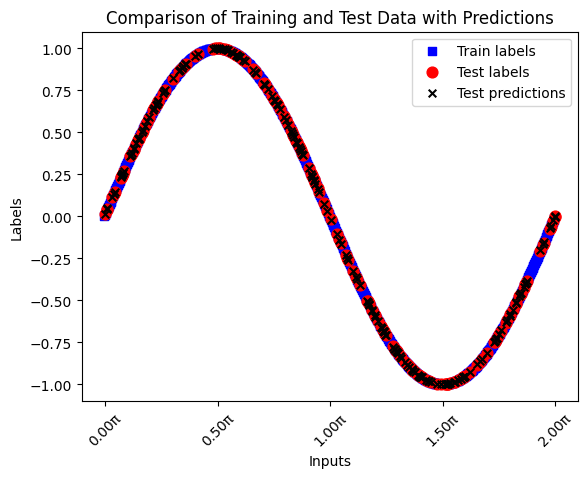

In [3]:
from modules.utils import plot_result
from modules.training import compute_predictions, cost_MSE

test_cost = cost_MSE(final_params, X_test, Y_test)
print(f"Cost (MSE) for training set: {costs[-1]:0.7f}")
print(f"Cost (MSE) for test set: {test_cost:0.7f}")
test_predictions = compute_predictions(X_test, final_params)

plot_result(X_test,Y_test, test_predictions,X_train,Y_train)

The plot visualizes the comparison between the training data, test data, and the predictions made by a Variational Quantum Circuit (VQC) for a regression problem where the goal is to predict the sine function.
* X-axis (Inputs): Represents the input values scaled in radians.
* Y-axis (Labels): Represents the corresponding sine values for the input values.

The plot and the provided MSE values (training set: 0.0000060, test set: 0.0000064) indicate that the VQC model has successfully learned the sine function, showing high accuracy and good generalization to the test data.

<a id="5"></a>
### Experiment 2 - different range of the input domain: $[2\pi, 7\pi]$
In order to evaluate our model, we modified the test set interval to $[2\pi, 7\pi]$. This allows us to assess the model's performance and generalization ability over a different range of the input domain.

Y_train: Length: 800
Y_test: Length: 200
Cost (MSE) for the interval [2π,7π]: 0.0000067


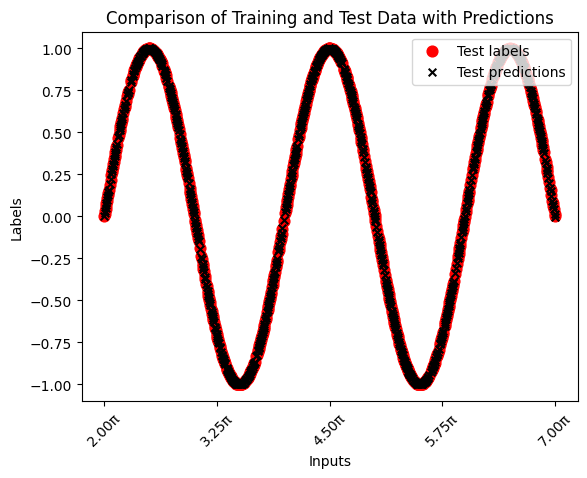

In [10]:
from modules.utils import create_data_sin_function
import pennylane.numpy as np
from modules.training import compute_predictions, cost_MSE
from modules.utils import plot_result

X_test_2, Y_test_2,_,_ = create_data_sin_function(1000,start= 2 * np.pi,stop = 7 * np.pi)

predictions = compute_predictions(X_test_2, final_params)
test_cost = cost_MSE(final_params, X_test_2, Y_test_2)
print(f"Cost (MSE) for the interval [2π,7π]: {test_cost:0.7f}")
plot_result(X_test_2,Y_test_2, predictions)

Mean Squared Error (MSE) values for different data sets:the training set, the test set, and a specific interval $[2\pi, 7\pi]$.
The model shows excellent performance with very low Mean Squared Error (MSE) values:

* Training Set: 0.0000060
* Test Set: 0.0000064
* Interval $[2\pi, 7\pi]$: 0.0000067

These values indicate that the model has learned the sine function accurately, generalizes well to unseen data, and maintains its performance across different intervals.

<a id="6"></a>
### Adjustment of number of points
In this section, we will select a sufficient number of data points to effectively learn the sine function. In the perform_training function, we run the training process on data generated using different numbers of points. The test cost is always measured on the same dataset: the interval $[2\pi, 7\pi]$, sampled with 1000 points.

In [1]:
from modules.utils import perform_training

num_points_array = [1000, 100, 50, 30, 20, 10, 5, 4, 3, 2, 1]
perform_training(num_points_array)

Epoch: 0 | Cost: 1.0042563
Epoch: 1 | Cost: 0.8058643
Epoch: 2 | Cost: 0.6185639
Epoch: 3 | Cost: 0.4552217
Epoch: 4 | Cost: 0.3228943
Epoch: 5 | Cost: 0.2222781
Epoch: 6 | Cost: 0.1495629
Epoch: 7 | Cost: 0.0989867
Epoch: 8 | Cost: 0.0647640
Epoch: 9 | Cost: 0.0420442
Epoch: 10 | Cost: 0.0271539
Epoch: 11 | Cost: 0.0174777
Epoch: 12 | Cost: 0.0112248
Epoch: 13 | Cost: 0.0071987
Epoch: 14 | Cost: 0.0046124
Epoch: 15 | Cost: 0.0029536
Epoch: 16 | Cost: 0.0018906
Epoch: 17 | Cost: 0.0012099
Epoch: 18 | Cost: 0.0007742
Epoch: 19 | Cost: 0.0004953
Epoch: 20 | Cost: 0.0003169
Epoch: 21 | Cost: 0.0002027
Epoch: 22 | Cost: 0.0001297
Epoch: 23 | Cost: 0.0000830
Epoch: 24 | Cost: 0.0000531
Epoch: 25 | Cost: 0.0000339
Epoch: 26 | Cost: 0.0000217
Epoch: 27 | Cost: 0.0000139
Epoch: 28 | Cost: 0.0000089
Epoch: 29 | Cost: 0.0000057
Final parameters:  [-0.78371322 -0.78371322]
Y_train: Length: 800
Y_test: Length: 200
Training completed with 1000 data points.
Final parameters: [-0.78371322 -0.78371322

Summary of all training runs:
Training completed with 1000 data points | Final parameters: [-0.78371322 -0.78371322] | Final cost: 0.0000057| Test cost: 0.0000057
Training completed with 100 data points | Final parameters: [-0.78378786 -0.78378786] | Final cost: 0.0000052| Test cost: 0.0000052
Training completed with 50 data points | Final parameters: [-0.78386678 -0.78386678] | Final cost: 0.0000048| Test cost: 0.0000047
Training completed with 30 data points | Final parameters: [-0.78396577 -0.78396577] | Final cost: 0.0000042| Test cost: 0.0000041
Training completed with 20 data points | Final parameters: [-0.78408015 -0.78408015] | Final cost: 0.0000036| Test cost: 0.0000035
Training completed with 10 data points | Final parameters: [-0.7843687 -0.7843687] | Final cost: 0.0000023| Test cost: 0.0000022
Training completed with 5 data points | Final parameters: [-0.78475925 -0.78475925] | Final cost: 0.0000010| Test cost: 0.0000008
**Training completed with 4 data points | Final parameters: [-0.78488824 -0.78488824] | Final cost: 0.0000007| Test cost: 0.0000005**
Training completed with 3 data points | Final parameters: [0.78539681 0.78539681] | Final cost: 0.0000000| Test cost: 1.9983954
Training completed with 2 data points | Final parameters: [0.78539681 0.78539681] | Final cost: 0.0000000| Test cost: 2.0330546
Training completed with 1 data points | Final parameters: [0.78539681 0.78539681] | Final cost: 0.0000000| Test cost: 1.9623261

The summary of all training runs provides insights into the performance of the quantum model with varying numbers of data points. Here is a detailed analysis:
*The parameters tend to converge to similar values as the number of data points increases.
* An increase in the number of data points results in a slight increase in the cost function, suggesting a trade-off between model complexity and training data volume.
* It is evident that with the given training parameters, the model requires only 4 data points to effectively learn the sine function.
* For cases with 3, 2, and 1 data points, despite achieving a final cost of zero, the test cost remains significantly high, indicating overfitting and poor generalization performance..


<a id="6"></a>
### Training for more complicated function

In [1]:
from modules.utils import create_data_advance_function
import pennylane.numpy as np
X_train, Y_train, X_test, Y_test = create_data_advance_function(1000,start = -2* np.pi ,stop=2*np.pi)

Y_train: Length: 800
Y_test: Length: 200


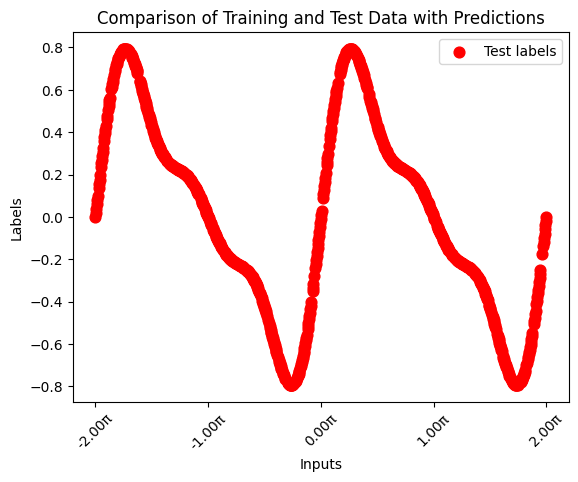

In [2]:
from modules.utils import plot_result
plot_result(X_train, Y_train,)

In [3]:
import pennylane as qml
import pennylane.numpy as np
from modules.training import cost_MSE, training

num_epochs = 100
opt = qml.AdamOptimizer(stepsize=0.1)
init_params = np.array([0.1, 0.1], requires_grad=True)

final_params,costs = training(num_epochs, opt, cost_MSE,init_params, X_train, Y_train)

Epoch: 0 | Cost: 0.7177873
Epoch: 1 | Cost: 0.6032924
Epoch: 2 | Cost: 0.4929017
Epoch: 3 | Cost: 0.3916076
Epoch: 4 | Cost: 0.3040416
Epoch: 5 | Cost: 0.2340185
Epoch: 6 | Cost: 0.1839991
Epoch: 7 | Cost: 0.1545622
Epoch: 8 | Cost: 0.1440610
Epoch: 9 | Cost: 0.1487067
Epoch: 10 | Cost: 0.1632301
Epoch: 11 | Cost: 0.1819906
Epoch: 12 | Cost: 0.2000977
Epoch: 13 | Cost: 0.2141121
Epoch: 14 | Cost: 0.2221982
Epoch: 15 | Cost: 0.2238950
Epoch: 16 | Cost: 0.2197459
Epoch: 17 | Cost: 0.2109422
Epoch: 18 | Cost: 0.1990333
Epoch: 19 | Cost: 0.1856984
Epoch: 20 | Cost: 0.1725584
Epoch: 21 | Cost: 0.1610139
Epoch: 22 | Cost: 0.1521070
Epoch: 23 | Cost: 0.1464203
Epoch: 24 | Cost: 0.1440312
Epoch: 25 | Cost: 0.1445394
Epoch: 26 | Cost: 0.1471718
Epoch: 27 | Cost: 0.1509470
Epoch: 28 | Cost: 0.1548647
Epoch: 29 | Cost: 0.1580762
Epoch: 30 | Cost: 0.1600040
Epoch: 31 | Cost: 0.1603926
Epoch: 32 | Cost: 0.1592972
Epoch: 33 | Cost: 0.1570221
Epoch: 34 | Cost: 0.1540313
Epoch: 35 | Cost: 0.1508475
Ep

Cost (MSE) for training set: 0.1487370
Cost (MSE) for test set: 0.1788118


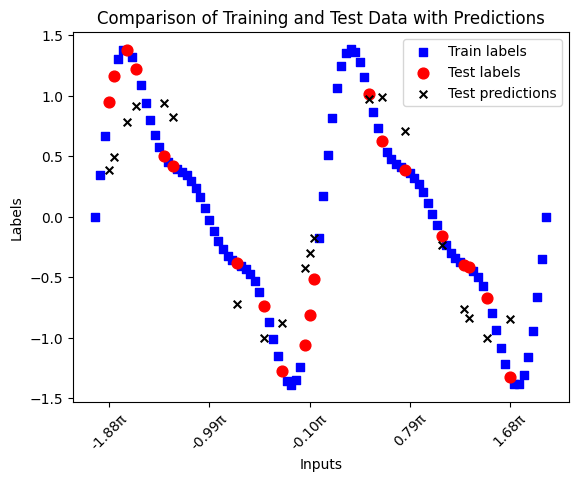

In [15]:
from modules.utils import plot_result
from modules.training import compute_predictions, cost_MSE

test_cost = cost_MSE(final_params, X_test, Y_test)
print(f"Cost (MSE) for training set: {costs[-1]:0.7f}")
print(f"Cost (MSE) for test set: {test_cost:0.7f}")
test_predictions = compute_predictions(X_test, final_params)

plot_result(X_test,Y_test, test_predictions,X_train,Y_train)

Y_train: Length: 800
Y_test: Length: 200
Cost (MSE) for the interval [2π,7π]: 0.1593539


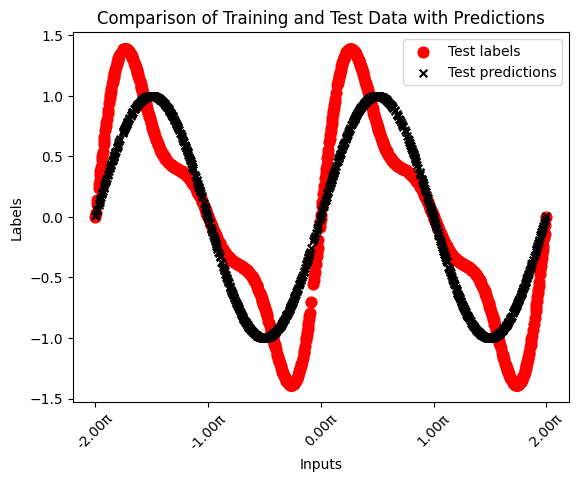

In [16]:
from modules.utils import create_data_advance_function
import pennylane.numpy as np
from modules.training import compute_predictions, cost_MSE
from modules.utils import plot_result

X_test_2, Y_test_2,_,_ = create_data_advance_function(1000,start= 2 * np.pi,stop = 7 * np.pi)

predictions = compute_predictions(X_test_2, final_params)
test_cost = cost_MSE(final_params, X_test_2, Y_test_2)
print(f"Cost (MSE) for the interval [2π,7π]: {test_cost:0.7f}")
plot_result(X_test_2,Y_test_2, predictions)

Above, we observe that this quantum model is capable of fitting only a sine function. In other words, this quantum model (utilizing a single Pauli-X rotation) can only learn to fit a Fourier series of a single frequency, and this is possible only if that frequency exactly matches the scaling of the data. Regardless of the chosen weights, the single qubit model for $L=1$ will always represent a sine function of a fixed frequency. The weights merely adjust the amplitude, vertical shift, and phase of the sine wave.